## Libraries

In [ ]:
!pip install numerapi
from numerapi import NumerAPI

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import tensorflow as tf

import os
import random
import glob
import pathlib
import scipy
import time
import datetime
import gc
from sklearn import preprocessing

# visualize
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.express as px

sns.set_context("talk")
style.use("seaborn-colorblind")

import warnings
warnings.simplefilter("ignore")

## Config

In [ ]:
today = datetime.datetime.now().strftime("%Y-%m-%d")
today

'2021-10-27'

In [ ]:
OUTPUT_DIR = "./"

In [ ]:
# Logging is always nice for your experiment:)
def init_logger(log_file="train.log"):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger(log_file=f"{today}.log")
logger.info("Start Logging...")

Start Logging...


## Check computing environment

In [ ]:
# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print("Your runtime has {:.1f} gigabytes of available RAM\n".format(ram_gb))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won"t be saved outside of the current session

Your runtime has 54.8 gigabytes of available RAM



## Fetch data

In [ ]:
# good features from https://forum.numer.ai/t/feature-selection-with-borutashap/4145
keys = ["era", "data_type", ]
targets = ["target", "target_janet_20", "target_george_20"]
features = [
                "feature_unwonted_trusted_fixative",
                "feature_introvert_symphysial_assegai",
                "feature_jerkwater_eustatic_electrocardiograph",
                "feature_canalicular_peeling_lilienthal",
                "feature_unvaried_social_bangkok",
                "feature_crowning_frustrate_kampala",
                "feature_store_apteral_isocheim",
                "feature_haziest_lifelike_horseback",
                "feature_grandmotherly_circumnavigable_homonymity",
                "feature_assenting_darn_arthropod",
                "feature_beery_somatologic_elimination",
                "feature_cambial_bigoted_bacterioid",
                "feature_unaired_operose_lactoprotein",
                "feature_moralistic_heartier_typhoid",
                "feature_twisty_adequate_minutia",
                "feature_unsealed_suffixal_babar",
                "feature_planned_superimposed_bend",
                "feature_winsome_irreproachable_milkfish",
                "feature_flintier_enslaved_borsch",
                "feature_agile_unrespited_gaucho",
                "feature_glare_factional_assessment",
                "feature_slack_calefacient_tableau",
                "feature_undivorced_unsatisfying_praetorium",
                "feature_silver_handworked_scauper",
                "feature_communicatory_unrecommended_velure",
                "feature_stylistic_honduran_comprador",
                "feature_travelled_semipermeable_perruquier",
                "feature_bhutan_imagism_dolerite",
                "feature_lofty_acceptable_challenge",
                "feature_antichristian_slangiest_idyllist",
                "feature_apomictical_motorized_vaporisation",
                "feature_buxom_curtained_sienna",
                "feature_gullable_sanguine_incongruity",
                "feature_unforbidden_highbrow_kafir",
                "feature_chuffier_analectic_conchiolin",
                "feature_branched_dilatory_sunbelt",
                "feature_univalve_abdicant_distrail",
                "feature_exorbitant_myeloid_crinkle"
                ]

logger.info("{:,} Targets: {}".format(len(targets), targets))
logger.info("{:,} Features: {}".format(len(features), features))

3 Targets: ['target', 'target_janet_20', 'target_george_20']
38 Features: ['feature_unwonted_trusted_fixative', 'feature_introvert_symphysial_assegai', 'feature_jerkwater_eustatic_electrocardiograph', 'feature_canalicular_peeling_lilienthal', 'feature_unvaried_social_bangkok', 'feature_crowning_frustrate_kampala', 'feature_store_apteral_isocheim', 'feature_haziest_lifelike_horseback', 'feature_grandmotherly_circumnavigable_homonymity', 'feature_assenting_darn_arthropod', 'feature_beery_somatologic_elimination', 'feature_cambial_bigoted_bacterioid', 'feature_unaired_operose_lactoprotein', 'feature_moralistic_heartier_typhoid', 'feature_twisty_adequate_minutia', 'feature_unsealed_suffixal_babar', 'feature_planned_superimposed_bend', 'feature_winsome_irreproachable_milkfish', 'feature_flintier_enslaved_borsch', 'feature_agile_unrespited_gaucho', 'feature_glare_factional_assessment', 'feature_slack_calefacient_tableau', 'feature_undivorced_unsatisfying_praetorium', 'feature_silver_handwork

## NumerAPI

In [ ]:
# setup API
napi = NumerAPI()
current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament
logger.info("NumerAPI is setup!")

NumerAPI is setup!
2021-10-27 23:04:07,108 INFO __main__: NumerAPI is setup!


## Training data

In [ ]:
%%time

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
napi.download_dataset("numerai_training_data_int8.parquet", "numerai_training_data_int8.parquet")
training_data = pd.read_parquet("numerai_training_data_int8.parquet")

# already select features and targets
training_data = training_data[keys + features + targets]

# example pred doesn"t exist for training data
training_data["example_pred"] = np.nan

print(training_data.shape)
training_data.head()

2021-10-27 23:04:08,081 INFO numerapi.utils: starting download
numerai_training_data_int8.parquet: 1.01GB [00:56, 17.9MB/s]                            


(2412105, 44)
CPU times: user 45.9 s, sys: 12.6 s, total: 58.5 s
Wall time: 1min 4s


#### Validation data (and example predictions)

In [ ]:
%%time

napi.download_dataset("numerai_validation_data_int8.parquet", f"numerai_validation_data_int8.parquet")
validation_data = pd.read_parquet("numerai_validation_data_int8.parquet")

# already select features and targets
validation_data = validation_data[keys + features + targets]

# example prediction
napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")
validation_example_preds = pd.read_parquet("example_validation_predictions.parquet")

validation_data["example_pred"] = validation_example_preds["prediction"].values

print(validation_data.shape)
validation_data.head()

2021-10-27 23:05:12,632 INFO numerapi.utils: starting download
numerai_validation_data_int8.parquet: 228MB [00:15, 15.1MB/s]                           
2021-10-27 23:05:30,337 INFO numerapi.utils: starting download
example_validation_predictions.parquet: 13.0MB [00:01, 6.52MB/s]                            


(539658, 44)
CPU times: user 10.7 s, sys: 4.88 s, total: 15.6 s
Wall time: 21 s


#### Tournament data (and example predictions)

In [ ]:
%%time

# load tournament data
napi.download_dataset("numerai_tournament_data_int8.parquet", f"numerai_tournament_data_int8.parquet")
tournament_data = pd.read_parquet(f"numerai_tournament_data_int8.parquet")

# already select features and targets
tournament_data = tournament_data[keys + features + targets]

# example predictions
napi.download_dataset("example_predictions.parquet", f"example_predictions_{current_round}.parquet")
tournament_example_preds = pd.read_parquet(f"example_predictions_{current_round}.parquet")

tournament_data = tournament_data.merge(
    tournament_example_preds
    , how="left"
    , on="id"
).rename(columns={"prediction": "example_pred"})

print(tournament_data.shape)
tournament_data.head()

2021-10-27 23:05:34,037 INFO numerapi.utils: starting download
numerai_tournament_data_int8.parquet: 582MB [00:35, 16.4MB/s]                           
2021-10-27 23:06:15,296 INFO numerapi.utils: starting download
example_predictions_287.parquet: 33.5MB [00:03, 9.16MB/s]                            


(1412940, 44)
CPU times: user 29 s, sys: 10.5 s, total: 39.5 s
Wall time: 48.9 s


#### Merge all, only using "good features"

In [ ]:
%%time

# merge all
feature_df = pd.DataFrame()
for d in [training_data, validation_data, tournament_data]:
    feature_df = pd.concat([
        feature_df
        , d
    ])
    del d
    gc.collect()


print(feature_df.shape)
feature_df.head()

(4364703, 44)
CPU times: user 881 ms, sys: 75.7 ms, total: 957 ms
Wall time: 949 ms


In [ ]:
# Do we have all the data type?
feature_df["data_type"].value_counts()

train         2412105
test          1407586
validation     539658
live             5354
Name: data_type, dtype: int64

## EDA (Exploratory Data Analysis)

2021-10-27 23:06:23,226 INFO numexpr.utils: NumExpr defaulting to 8 threads.


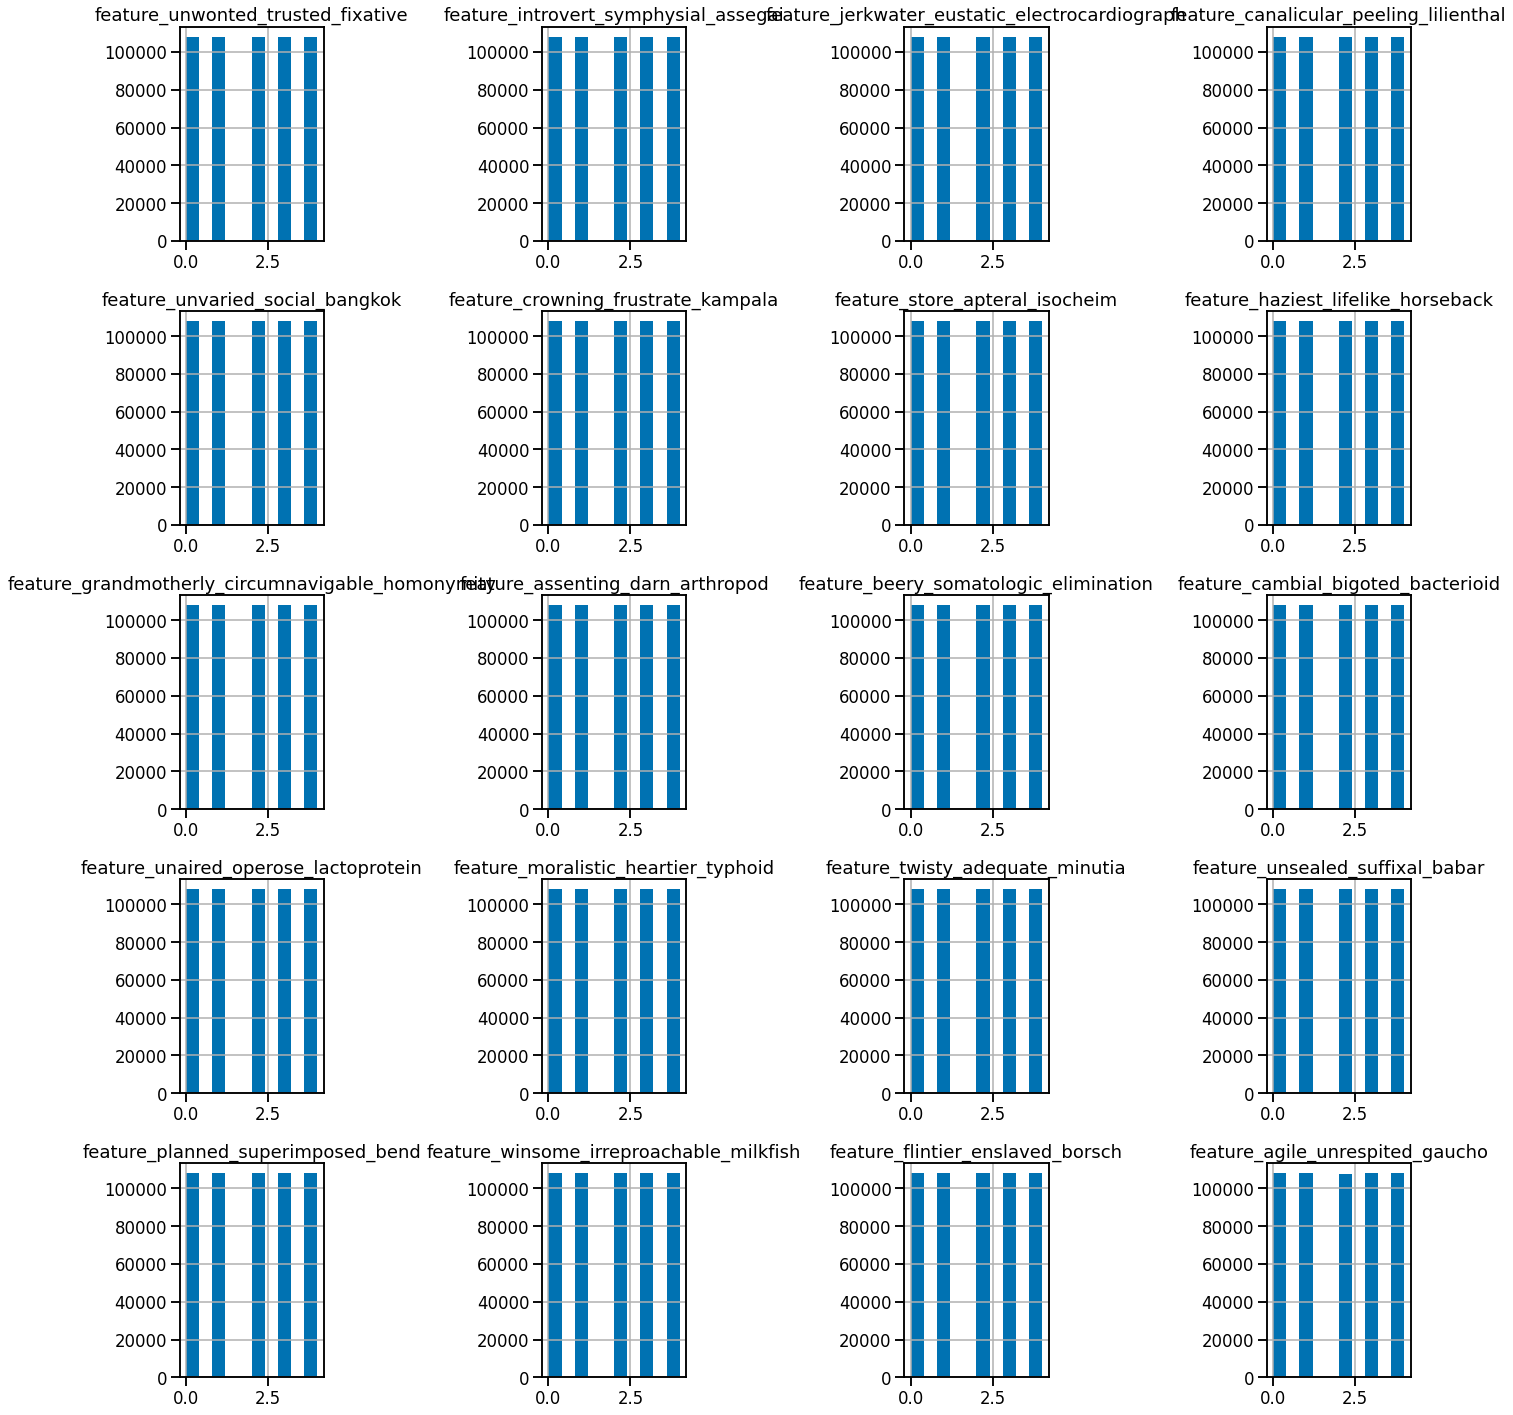

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
ax = ax.flatten()

for i, f in enumerate(np.array(features)[:20]):
    feature_df.query("data_type=='validation'")[f].hist(ax=ax[i])
    ax[i].set_title(f)
plt.tight_layout()

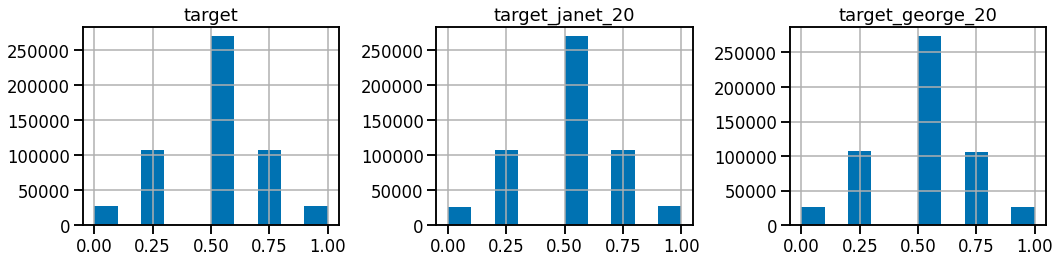

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()

for i, f in enumerate(np.array(targets)[:3]):
    feature_df.query("data_type=='validation'")[f].hist(ax=ax[i])
    ax[i].set_title(f)
plt.tight_layout()

## Modeling

#### Define model

In [ ]:
params = {
    "feat_len": len(features)
    , "hidden_units": (128, 64, 64)
    , "out_dim": len(targets)
    , "lr": 0.005
    , "batch_size": 4096
    , "epochs": 1000
}  

# set seed for the reproducibility
def seed_everything(seed : int):    
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything(20210901)    
    
# define a multi-layer perceptron model
def create_model(params):
    """Simple multi-layer perceptron
    """
    len_feat = params["feat_len"]
    hidden_units = params["hidden_units"]
    lr = params["lr"]
    
    # input
    inputs = tf.keras.Input(shape=(len_feat,), name="num_data")
    
    # Add one or more hidden layers
    x = tf.keras.layers.Dense(hidden_units[0], activation="relu")(inputs)
    for n_hidden in hidden_units[1:]:
        x = tf.keras.layers.Dense(n_hidden, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.05)(x)
        x = tf.keras.layers.GaussianNoise(0.01)(x)

    # output
    outs = []
    for i in range(params["out_dim"]):
        outs.append(tf.keras.layers.Dense(1, activation="linear", name=f"target{i+1}")(x))
    
    # compile
    model = tf.keras.Model(inputs=inputs, outputs=outs)
    loss = "mse"
    loss_weights = [1] * params["out_dim"]
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=lr/100)
    model.compile(
        loss=loss
        , loss_weights=loss_weights
        , optimizer=optimizer
        , metrics=[]
    )
    
    return model

model = create_model(params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num_data (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          4992        num_data[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64)           0           dense_1[0][0]                    
______________________________________________________________________________________________

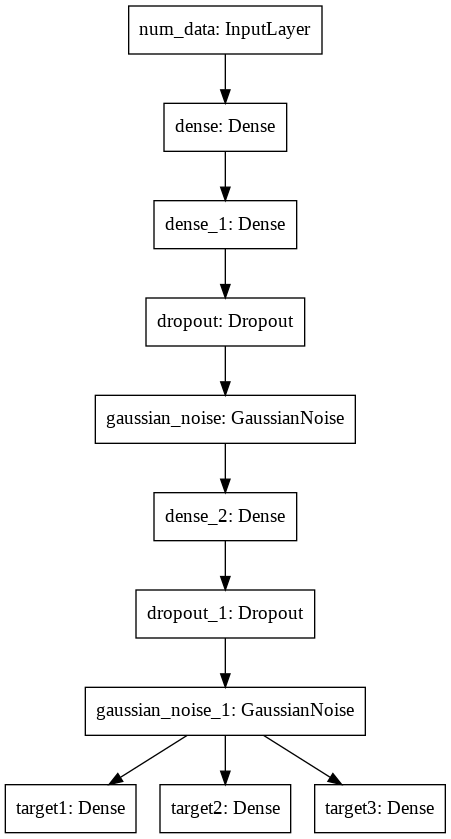

In [ ]:
tf.keras.utils.plot_model(model)

#### Train

In [ ]:
# fit model with cross validation
def get_time_series_cross_val_splits(data, cv=3, embargo=4, ERA_COL="era"):
    """Numerai data splitter for cross validation
    use embargo = 12 when use target_XXX_60 to avoid potential leakage (target days / 5)
    
    https://github.com/numerai/example-scripts/blob/master/utils.py
    """
    all_train_eras = data[ERA_COL].unique()
    len_split = len(all_train_eras) // cv
    test_splits = [all_train_eras[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last eras, in case the number of eras wasn"t divisible by cv
    test_splits[-1] = np.append(test_splits[-1], all_train_eras[-1])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the eras that aren"t in the test split
        train_split_not_embargoed = [e for e in all_train_eras if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage.
        # one era is length 5, so we need to embargo by target_length/5 eras.
        # To be consistent for all targets, let"s embargo everything by 60/5 == 12 eras.
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo and abs(int(e) - test_split_min) > embargo]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

# define cross validation splits
ERA_COL = "era"
cv = 3
embargo = 4
train_test_zip = get_time_series_cross_val_splits(
    feature_df.query("data_type == 'train'"), cv=cv, embargo=embargo, ERA_COL=ERA_COL
)

# placeholder for each target
for i, t in enumerate(targets):
    feature_df[f"pred_{t}"] = 0

# get out of sample training preds via embargoed time series cross validation
print("entering time series cross validation loop")
for fold_id, train_test_split in enumerate(train_test_zip):
    # train test split
    print(f"doing split {fold_id+1} out of {cv}")
    train_split, test_split = train_test_split

    # dataset
    train_set = {
        "X": feature_df.query(f"{ERA_COL} in @train_split")[features].values
        , "y": [feature_df.query(f"{ERA_COL} in @train_split")[t].fillna(0.5).values for t in targets]
    }
    val_set = {
        "X": feature_df.query(f"{ERA_COL} in @test_split")[features].values
        , "y": [feature_df.query(f"{ERA_COL} in @test_split")[t].fillna(0.5).values for t in targets]
    }
    print("Train-set shape: {}, valid-set shape: {}".format(
        train_set["X"].shape
        , val_set["X"].shape
    ))

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, verbose=2,
        mode="min", restore_best_weights=True)

    plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=7, verbose=2,
        mode="min")

    checkpoint_path = f"model_fold{fold_id}.hdf5"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
         checkpoint_path, 
         save_weights_only=True,
         verbose=1)

    # training
    tf.keras.backend.clear_session()
    model = create_model(params)
    model.fit(
        train_set["X"], 
        train_set["y"],               
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        validation_data=(val_set["X"], val_set["y"]),
        callbacks=[es, plateau, cp_callback],
        verbose=1
    )

    # inference
    preds = model.predict(feature_df.loc[~feature_df["data_type"].isin(["train"]), features].values)
    for i, t in enumerate(targets):
        feature_df.loc[~feature_df["data_type"].isin(["train"]), f"pred_{t}"] += preds[i].ravel() / cv

entering time series cross validation loop
doing split 1 out of 3
Train-set shape: (1710885, 38), valid-set shape: (684453, 38)
Epoch 1/1000
418/418 [==============================] - 5s 5ms/step - loss: 0.1835 - target1_loss: 0.0652 - target2_loss: 0.0561 - target3_loss: 0.0622 - val_loss: 0.1486 - val_target1_loss: 0.0499 - val_target2_loss: 0.0495 - val_target3_loss: 0.0492

Epoch 00001: saving model to model_fold0.hdf5
Epoch 2/1000
418/418 [==============================] - 2s 4ms/step - loss: 0.1512 - target1_loss: 0.0509 - target2_loss: 0.0503 - target3_loss: 0.0500 - val_loss: 0.1485 - val_target1_loss: 0.0499 - val_target2_loss: 0.0494 - val_target3_loss: 0.0492

Epoch 00002: saving model to model_fold0.hdf5
Epoch 3/1000
418/418 [==============================] - 2s 4ms/step - loss: 0.1503 - target1_loss: 0.0506 - target2_loss: 0.0500 - target3_loss: 0.0497 - val_loss: 0.1485 - val_target1_loss: 0.0499 - val_target2_loss: 0.0494 - val_target3_loss: 0.0492

Epoch 00003: saving m

## Validation score

In [ ]:
# https://github.com/numerai/example-scripts/blob/master/utils.py
def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method="ordinal") - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)


def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it"s centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)


def get_feature_neutral_mean(df, prediction_col, ERA_COL="era", TARGET_COL="target"):
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [prediction_col],
                                          feature_cols)[prediction_col]
    scores = df.groupby(ERA_COL).apply(
        lambda x: (unif(x["neutral_sub"]).corr(x[TARGET_COL]))).mean()
    return np.mean(scores)


def fast_score_by_date(df, columns, target, tb=None, era_col="era"):
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        era_pred = np.float64(df_era[columns].values.T)
        era_target = np.float64(df_era[target].values.T)

        if tb is None:
            ccs = np.corrcoef(era_target, era_pred)[0, 1:]
        else:
            tbidx = np.argsort(era_pred, axis=1)
            tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
            ccs = [np.corrcoef(era_target[tmpidx], tmppred[tmpidx])[0, 1] for tmpidx, tmppred in zip(tbidx, era_pred)]
            ccs = np.array(ccs)

        computed.append(ccs)

    return pd.DataFrame(np.array(computed), columns=columns, index=df[era_col].unique())


def validation_metrics(validation_data, pred_cols, example_col, fast_mode=False, ERA_COL="era", TARGET_COL="target"):
    validation_stats = pd.DataFrame()
    feature_cols = [c for c in validation_data if c.startswith("feature_")]
    for pred_col in pred_cols:
        # Check the per-era correlations on the validation set (out of sample)
        validation_correlations = validation_data.groupby(ERA_COL).apply(
            lambda d: unif(d[pred_col]).corr(d[TARGET_COL]))

        mean = validation_correlations.mean()
        std = validation_correlations.std(ddof=0)
        sharpe = mean / std

        validation_stats.loc["mean", pred_col] = mean
        validation_stats.loc["std", pred_col] = std
        validation_stats.loc["sharpe", pred_col] = sharpe

        rolling_max = (validation_correlations + 1).cumprod().rolling(window=9000,  # arbitrarily large
                                                                      min_periods=1).max()
        daily_value = (validation_correlations + 1).cumprod()
        max_drawdown = -((rolling_max - daily_value) / rolling_max).max()
        validation_stats.loc["max_drawdown", pred_col] = max_drawdown

        payout_scores = validation_correlations.clip(-0.25, 0.25)
        payout_daily_value = (payout_scores + 1).cumprod()

        apy = (
            (
                (payout_daily_value.dropna().iloc[-1])
                ** (1 / len(payout_scores))
            )
            ** 49  # 52 weeks of compounding minus 3 for stake compounding lag
            - 1
        ) * 100

        validation_stats.loc["apy", pred_col] = apy

        if not fast_mode:
            # Check the feature exposure of your validation predictions
            max_per_era = validation_data.groupby(ERA_COL).apply(
                lambda d: d[feature_cols].corrwith(d[pred_col]).abs().max())
            max_feature_exposure = max_per_era.mean()
            validation_stats.loc["max_feature_exposure", pred_col] = max_feature_exposure

            # Check feature neutral mean
            feature_neutral_mean = get_feature_neutral_mean(validation_data, pred_col)
            validation_stats.loc["feature_neutral_mean", pred_col] = feature_neutral_mean

            # Check top and bottom 200 metrics (TB200)
            tb200_validation_correlations = fast_score_by_date(
                validation_data,
                [pred_col],
                TARGET_COL,
                tb=200,
                era_col=ERA_COL
            )

            tb200_mean = tb200_validation_correlations.mean()[pred_col]
            tb200_std = tb200_validation_correlations.std(ddof=0)[pred_col]
            tb200_sharpe = mean / std

            validation_stats.loc["tb200_mean", pred_col] = tb200_mean
            validation_stats.loc["tb200_std", pred_col] = tb200_std
            validation_stats.loc["tb200_sharpe", pred_col] = tb200_sharpe

        # MMC over validation
        mmc_scores = []
        corr_scores = []
        for _, x in validation_data.groupby(ERA_COL):
            series = neutralize_series(unif(x[pred_col]), (x[example_col]))
            mmc_scores.append(np.cov(series, x[TARGET_COL])[0, 1] / (0.29 ** 2))
            corr_scores.append(unif(x[pred_col]).corr(x[TARGET_COL]))

        val_mmc_mean = np.mean(mmc_scores)
        val_mmc_std = np.std(mmc_scores)
        corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
        corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)

        validation_stats.loc["mmc_mean", pred_col] = val_mmc_mean
        validation_stats.loc["corr_plus_mmc_sharpe", pred_col] = corr_plus_mmc_sharpe

        # Check correlation with example predictions
        per_era_corrs = validation_data.groupby(ERA_COL).apply(lambda d: unif(d[pred_col]).corr(unif(d[example_col])))
        corr_with_example_preds = per_era_corrs.mean()
        validation_stats.loc["corr_with_example_preds", pred_col] = corr_with_example_preds

    # .transpose so that stats are columns and the model_name is the row
    return validation_stats.transpose()

In [ ]:
%%time

# score
pred_cols = [f for f in feature_df.columns if "pred_" in f]
val_scores = validation_metrics(
    feature_df.query("data_type == 'validation'"), pred_cols, "example_pred", fast_mode=True,
    ERA_COL="era", TARGET_COL="target"
    )

CPU times: user 4.72 s, sys: 14.6 s, total: 19.3 s
Wall time: 4.46 s


In [ ]:
# validation scoring results
val_scores.style.background_gradient(cmap="viridis", axis=0)

,mean,std,sharpe,max_drawdown,apy,mmc_mean,corr_plus_mmc_sharpe,corr_with_example_preds
pred_target,0.016483,0.028456,0.579251,-0.141597,118.556171,0.004559,0.472213,0.411375
pred_target_janet_20,0.014986,0.025400,0.589990,-0.128480,104.127961,0.004578,0.481084,0.352521
pred_target_george_20,0.007981,0.022241,0.358826,-0.204617,45.883646,-0.000928,0.198665,0.353639


## Upload predictions

In [ ]:
# drop train, as it is no longer necessary for submission
sub_df = feature_df.query("data_type != 'train'").copy()
del feature_df
gc.collect()

# rank per era for safe ensemble
sub_df[pred_cols + ["example_pred"]] = sub_df.groupby("era").apply(lambda d: d[pred_cols + ["example_pred"]].rank(pct=True))

# ensemble
sub_df["prediction"] = sub_df[pred_cols + ["example_pred"]].mean(axis=1)

# neutralization
# sub_df["prediction"] = neutralize(
#     tmp, 
#     columns=["prediction"], 
#     neutralizers=features, 
#     proportion=0.5, 
#     normalize=True,
#     era_col="era"
#     )

# scale your prediction from 0 to 1
sub_df["prediction"] = preprocessing.MinMaxScaler().fit_transform(
    sub_df["prediction"].values.reshape(-1, 1)
)

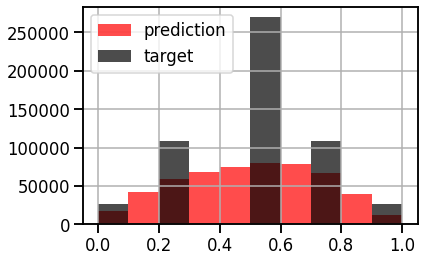

In [ ]:
# check histogram of target and our prediction
sub_df.query("data_type == 'validation'")["prediction"].hist(color="r", alpha=0.5, label="prediction")
sub_df.query("data_type == 'validation'")["target"].hist(color="k", alpha=0.7, label="target")
plt.legend()

In [ ]:
!pip install kaggle_secrets

ERROR: Could not find a version that satisfies the requirement kaggle_secrets (from versions: none)
ERROR: No matching distribution found for kaggle_secrets


In [ ]:
# my secret API key...;D When you submit your own model prediciton, you need to use yours of course:
# public_id = "Your_numerai_public_id"
# secret_key = "Your_numerai_secret_key"

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
public_id = user_secrets.get_secret("public_id")
secret_key = user_secrets.get_secret("secret_key")

ModuleNotFoundError: ignored

In [ ]:
# setup numerapi with authentification for submission
napi = NumerAPI(public_id, secret_key)
model_ids = napi.get_models()

In [ ]:
# check submission df
logger.info(sub_df.shape)
sub_df.tail()

In [ ]:
# upload
def upload(napi, sub_df, upload_type="diagnostics", slot_name="XXX"):
    """Upload prediction to Numerai    
    """
    
    # fetch model slot id
    model_slots = napi.get_models()
    slot_id = model_slots[slot_name.lower()]
    
    # format submission dataframe
    sdf = sub_df.index.to_frame()
    sdf["data_type"] = sub_df["data_type"].values
    sdf["prediction"] = sub_df["prediction"].values
    
    # upload
    if upload_type.lower() == "diagnostics": # diagnostics
        sdf.query("data_type == 'validation'")[["id", "prediction"]].to_csv(f"./prediction.csv", index=False)
        try:
            napi.upload_diagnostics(f"./prediction.csv", model_id=slot_id, )
            print(f"{slot_name} submitted for diagnositics!")
        except Exception as e:
            print(f"{slot_name}: {e}")
    else: # predictions for the tournament data
        in_data = ["test", "live"]
        sdf.query("data_type in @in_data")[["id", "prediction"]].to_csv(f"./prediction.csv", index=False)
        try:
            napi.upload_predictions("./prediction.csv", model_id=slot_id, version=2)
            print(f"{slot_name} submitted for predictions!")
        except Exception as e:
            print(f"{slot_name}: {e}")

In [ ]:
# upload diagnostics
your_model_slot_name = "WHITECAT_01" # use your model slot name, of course
upload(napi, sub_df, upload_type="diagnostics", slot_name=your_model_slot_name)

In [ ]:
# upload predictions on test and live
upload(napi, sub_df, upload_type="predictions", slot_name=your_model_slot_name)